In [1]:
using NBInclude
@nbinclude("KIC1430163.ipynb")

General info:                 
Size of the subset:           3518
Mean of the flux:             2.125678e6
Variance of the subset:       209401.3
Mean of the time differences: 0.026616617260856176
Lomb–Scargle periodogram:
The peak is at 0.2222990081813975.
The relevant estimate of the period is 4.498445621421726.


In [10]:
# Unpack a tuple of parameters
function unpack(θ)
    A = θ[1]
    l = θ[2]
    P = θ[3]
    μ = θ[4]
    σ² = θ[5]
    return A, l, P, μ, σ²
end

# Calculate the negative log marginal likelihood
function nlml(θ)
    A, l, P, μ, σ² = unpack(θ)
    k = A * stretch(Stheno.EQ(), 1 / l^2) * Stheno.Cosine(P / 2)
    g = GP(μ, k, GPC())
    return -logpdf(g(t, σ²), f)
end
;

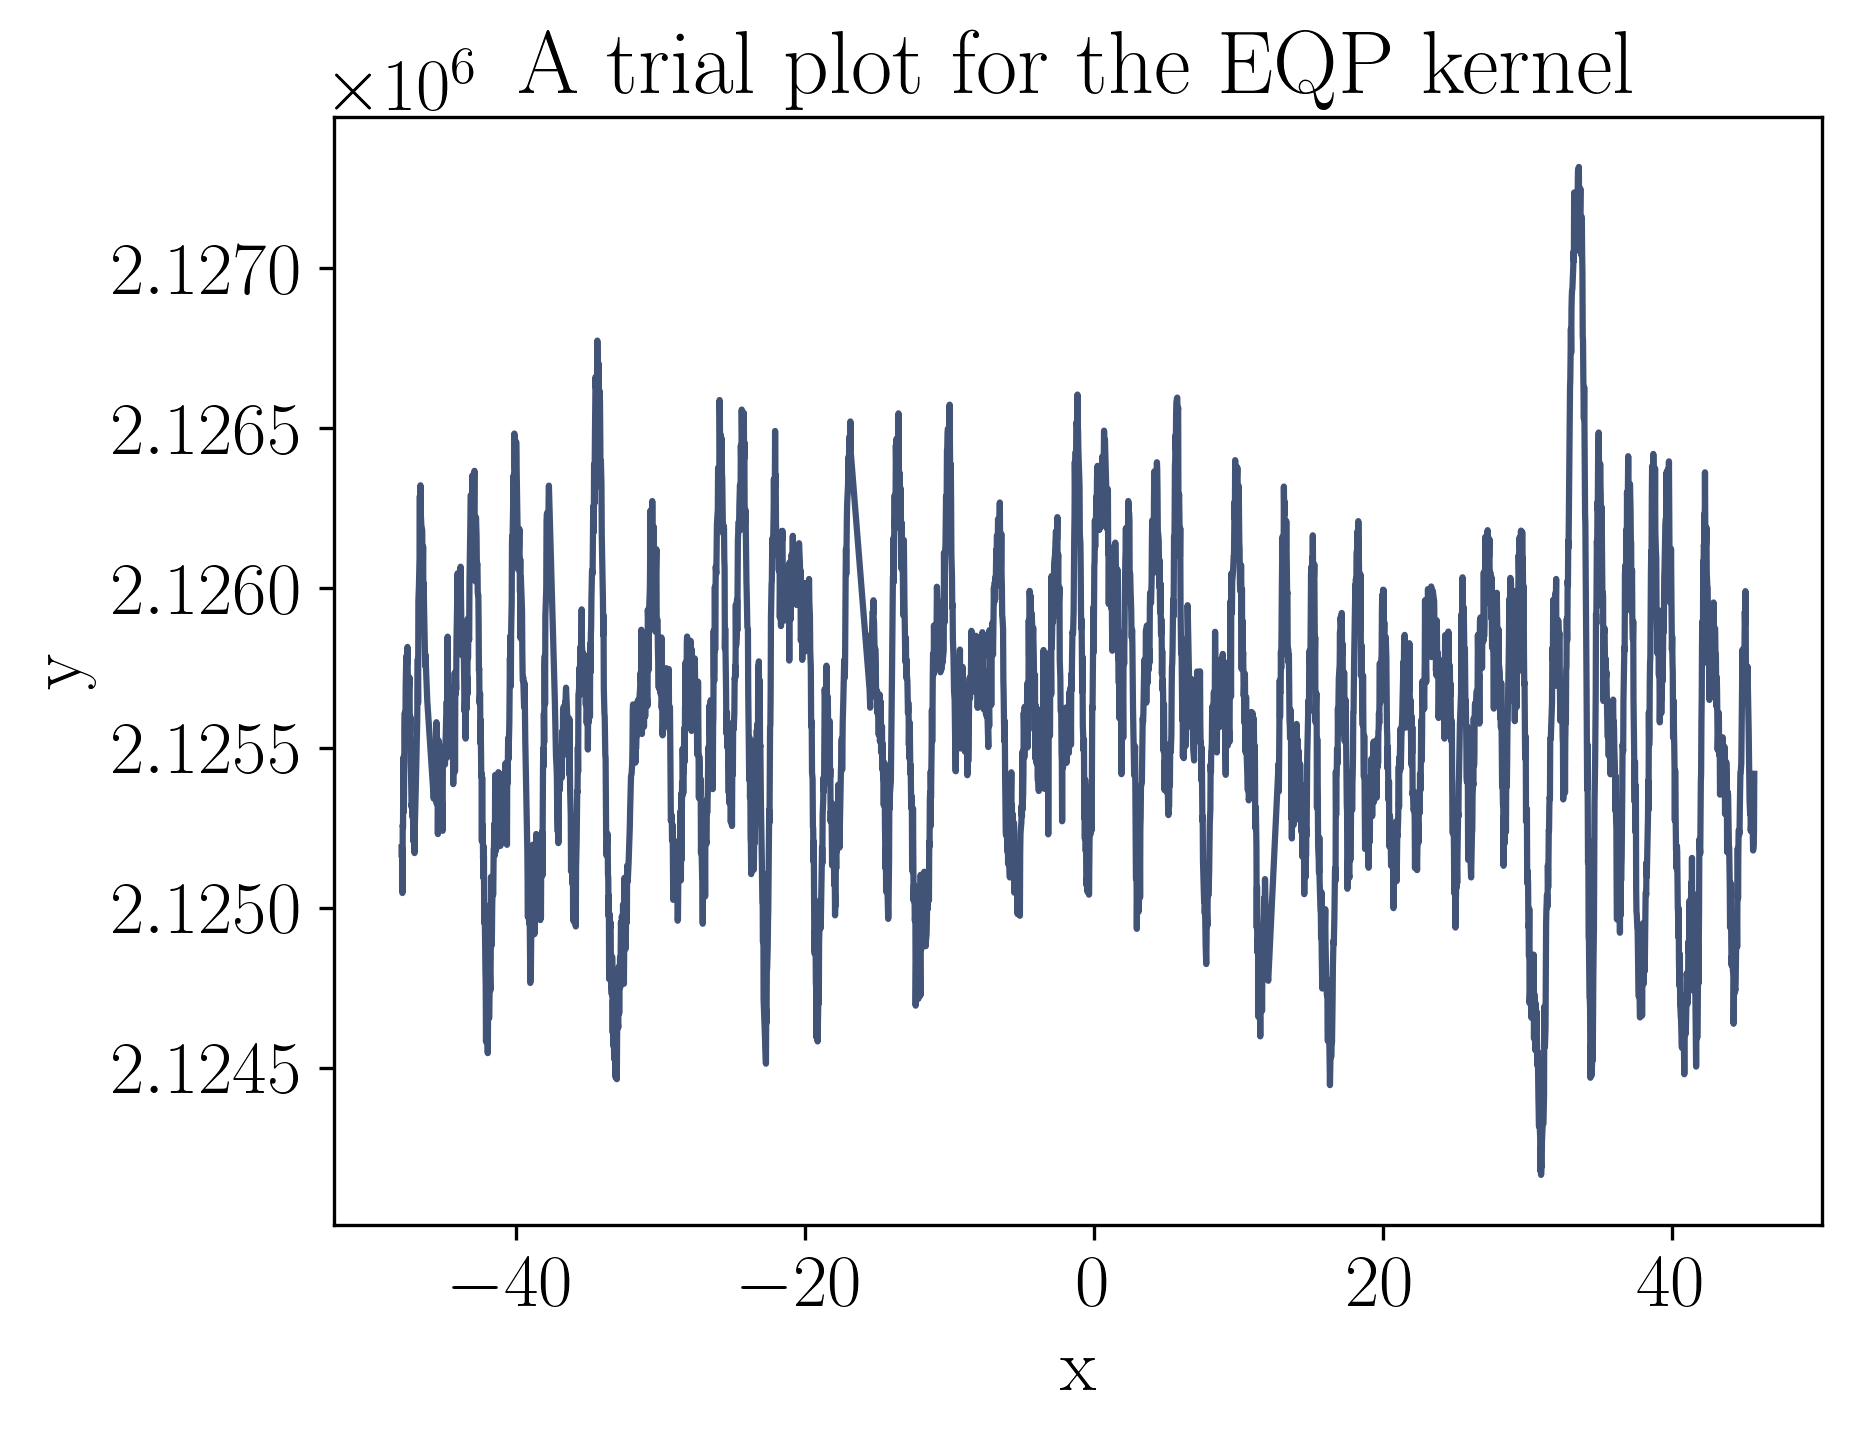

Negative log marginal likelihood: 21253.239040160737


In [51]:
# Select the trial parameters
Aₜ = σ²₀
lₜ = 0.60
Pₜ = P₀
μₜ = μ₀
σ²ₜ = 5500

# Create a kernel
EQP = Aₜ * stretch(Stheno.EQ(), 1 / lₜ^2) * Stheno.Cosine(Pₜ / 2)

# Create a Gaussian process
g = GP(μₜ, EQP, GPC())

# Take the values of one of the Gaussian process realizations
# on the time values of the original time series
x = t
y = rand(g(x, σ²ₜ))

plot(x, y; color)

title(L"\textrm{A trial plot for the EQP kernel}")
xlabel(L"\textrm{x}")
ylabel(L"\textrm{y}")

θ = [Aₜ, lₜ, Pₜ, μₜ, σ²ₜ]
println("Negative log marginal likelihood: ", nlml(θ))

In [185]:
# Collect a parameters vector
θ₀ = [σ²₀, 0.55, 3.88, μ₀, 6000]

# Define the lower and upper boundaries, respectively
θₗ = [209000.0, 0.45, 3.0, 2125650.0, 5950.0]
θᵤ = [210000.0, 0.7, 4.5, 2125750.0, 6050.0]

# Optimize the negative log marginal likelihood function
results = Optim.optimize(
    nlml,
    θ->Zygote.gradient(nlml, θ)[1],
    θₗ,
    θᵤ,
    θ₀,
    Fminbox(LBFGS()),
    Optim.Options(
        iterations = 10,
        show_trace = true,
        extended_trace = true,
        store_trace = false,
    );
    inplace = false,
)

Fminbox
-------
Initial mu = 0.0205539

Fminbox iteration 1
-------------------
Calling inner optimizer with mu = 0.0205539

(numbers below include barrier contribution)
Iter     Function value   Gradient norm 
     0     2.119242e+04     3.998282e+02
 * Current step size: 1.0
 * time: 0.0005290508270263672
 * g(x): [0.00013976047838235305, 399.8282216657727, -1.0873415027399378, 0.003565983494533929, -0.0024801570797695696]
 * x: [209401.328125, 0.55, 3.88, 2.125678e6, 6000.0]
     1     2.118634e+04     1.294103e+01
 * Current step size: 0.00028793417946751355
 * time: 181.7891490459442
 * g(x): [0.0002221468440328038, 12.941032637195681, -4.474617097632583, 0.0037150532062529013, 0.007061735604336403]
 * x: [209401.32812495975, 0.5209934034787261, 3.8802898882940404, 2.125677999998973e6, 6000.000000714111]
     2     2.118435e+04     1.696731e+01
 * Current step size: 0.14377606324365522
 * time: 547.1100471019745
 * g(x): [0.00022335871275657492, -16.967310814596907, -0.23341407161

LoadError: InterruptException:

The following cells will be removed later.

In [181]:
P = range(2, 10; step = 0.1)
for (i, Pᵢ) in enumerate(P)
    θₜ = [209401.23928068715, 0.55, Pᵢ, 2.125677794326631e6, 6000]
    g = Stheno.GP(θₜ[4], θₜ[1] * stretch(Stheno.EQ(), 1 / θₜ[2]^2) * Stheno.Cosine(θₜ[3] / 2), Stheno.GPC())
    println(Pᵢ, " "^3, -logpdf(g(t, θₜ[5]), f))
end

2.0   21220.748207337296
2.1   21216.04344851742
2.2   21212.111958993148
2.3   21208.81561845265
2.4   21206.04532580988
2.5   21203.713729221185
2.6   21201.750101982776
2.7   21200.09663351637
2.8   21198.705685165492
2.9   21197.537722653396
3.0   21196.55973435347
3.1   21195.74400518454
3.2   21195.067155118584
3.3   21194.509377371873
3.4   21194.053829168974
3.5   21193.68614039482
3.6   21193.394014270074
3.7   21193.166900537974
3.8   21192.9957262864
3.9   21192.872672948615
4.0   21192.790990582413
4.1   21192.744842445627
4.2   21192.729174355423
4.3   21192.739604434995
4.4   21192.772329726704
4.5   21192.8240468234
4.6   21192.891884207882
4.7   21192.97334440895
4.8   21193.06625442236
4.9   21193.16872311287
5.0   21193.27910453489
5.1   21193.395966283275
5.2   21193.51806213362
5.3   21193.64430834932
5.4   21193.77376312938
5.5   21193.90560875459
5.6   21194.039136054864
5.7   21194.17373087885
5.8   21194.308862292768
5.9   21194.444072275386
6.0   21194.57896671

In [180]:
σ² = range(6000, 7000; step = 10)
for (i, σ²ᵢ) in enumerate(σ²)
    θₜ = [209401.23928068715, 0.55, 3.88, 2.125677794326631e6, σ²ᵢ]
    g = Stheno.GP(θₜ[4], θₜ[1] * stretch(Stheno.EQ(), 1 / θₜ[2]^2) * Stheno.Cosine(θₜ[3] / 2), Stheno.GPC())
    println(σ²ᵢ, " "^3, -logpdf(g(t, θₜ[5]), f))
end

6000   21192.89377199526
6010   21192.871122543194
6020   21192.852758366884
6030   21192.838651445254
6040   21192.828773964407
6050   21192.82309831539
6060   21192.821597092785
6070   21192.82424309299
6080   21192.831009312045
6090   21192.841868944193
6100   21192.85679538002
6110   21192.875762204996
6120   21192.89874319754
6130   21192.925712327233
6140   21192.956643753583
6150   21192.99151182401
6160   21193.030291072537
6170   21193.07295621784
6180   21193.119482161925
6190   21193.169843988297
6200   21193.22401696101
6210   21193.281976522107
6220   21193.343698291137
6230   21193.40915806298
6240   21193.478331806567
6250   21193.55119566352
6260   21193.627725946233
6270   21193.70789913717
6280   21193.791691886752
6290   21193.87908101221
6300   21193.97004349613
6310   21194.06455648524
6320   21194.162597288665
6330   21194.264143376822
6340   21194.369172380102
6350   21194.47766208736
6360   21194.589590444717
6370   21194.70493555414
6380   21194.823675672164
63